In [2]:
# import libraries
import pandas as pd
import numpy as np
import time
import itertools
import pickle
import os
from tqdm import tqdm
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import aaanalysis as aa
aa.options["verbose"] = False
aa.options["random_state"] = 42

from rulekit.classification import RuleClassifier, ExpertRuleClassifier
from rulekit.params import Measures
from rulekit._helpers import *
from jpype.pickle import JPickler, JUnpickler

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from scipy.stats import pearsonr, kruskal

from src.utils import *
from src.utils_rules import *
from src.MHCRule import *

In [2]:
mhcbench_df = pd.read_csv('../Data/MHC-Bench_v2.csv',index_col=0)
mhcbench_df = mhcbench_df.rename(columns={'mhc':'allele',
                                          'binding':'y'})

BA_df = pd.read_csv('../Data/Data_HLA.csv',index_col=0)
BA_df = BA_df[BA_df['peptide_length']==9]


# Read count df
count_df = pd.read_csv('../Data/HLA_peptide_count.csv',index_col=0)

# HLA list
# Make sure we have atleast 10 peptides with atleast 6 +ve and -ve peptides
allele_ls = count_df[(count_df['positives']>5)&(count_df['negatives']>5)&(count_df['total']>10)]['allele'].to_list()

df_scales = aa.load_scales()
_ = RuleClassifier()

scale = 'KOEH090101'

Jun 25, 2024 1:21:58 PM com.rapidminer.tools.I18N <clinit>
INFO: Set locale to en.


In [3]:
# We calculate HLA distance matrix calculated from https://github.com/yshen25/HLA_clustering/blob/main/Computed_DistMtx/HLA-I.csv

hla_clus_distance_matrix = pd.read_csv('../Data/hla_precomputed.csv',sep='\t',index_col=0)
hla_clus_distance_matrix = hla_clus_distance_matrix + hla_clus_distance_matrix.T - np.diag(hla_clus_distance_matrix.values.diagonal())
hla_clus_distance_matrix

,A68_06,C14_02,C17_03,C07_18,C01_44,C08_13,B27_05,B40_49,A36_01,B35_28,...,A01_01,A02_22,B55_01,B27_14,A43_01,B44_05,B15_67,B82_01,B27_02,C07_172
A68_06,0.000000,6.801695,5.730471,6.988126,6.377638,5.755410,7.381747,6.683145,5.071609,6.695526,...,5.766923,4.408575,5.894471,7.178061,4.806797,7.103668,6.079333,6.464484,7.516713,7.287534
C14_02,6.801695,0.000000,5.440516,4.493339,4.342956,4.955746,7.271694,7.332272,6.584930,6.387906,...,6.841637,7.321320,5.942705,7.259143,6.188226,7.687058,6.289161,6.576104,7.330521,4.804015
C17_03,5.730471,5.440516,0.000000,5.664554,4.444519,2.124004,7.335898,5.862942,6.089659,6.360208,...,6.464770,5.726835,4.899286,7.262154,5.723918,6.587782,5.395740,5.763415,7.243303,6.048399
C07_18,6.988126,4.493339,5.664554,0.000000,6.059271,5.166018,6.052611,6.869193,6.762869,5.898686,...,7.053533,7.382374,6.307644,6.244666,6.616334,7.613234,6.602223,6.352031,6.118847,1.977624
C01_44,6.377638,4.342956,4.444519,6.059271,0.000000,3.909496,7.959477,6.367671,6.346465,6.815901,...,6.618869,6.363685,5.483764,7.789804,6.346236,6.773801,6.387642,5.984211,7.987259,6.331268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B44_05,7.103668,7.687058,6.587782,7.613234,6.773801,6.570861,7.446323,4.162484,7.307311,5.213317,...,6.965509,6.842212,7.154683,7.365374,7.550420,0.000000,6.571696,5.424567,7.538837,7.959812
B15_67,6.079333,6.289161,5.395740,6.602223,6.387642,5.461916,7.629644,6.027607,5.610002,5.430173,...,6.036837,6.073678,5.923092,7.476817,5.324589,6.571696,0.000000,6.963803,7.408869,6.861703
B82_01,6.464484,6.576104,5.763415,6.352031,5.984211,5.333871,7.416618,6.157392,7.012676,6.508145,...,6.594500,7.289704,4.891566,7.360000,7.329936,5.424567,6.963803,0.000000,7.532769,6.735044
B27_02,7.516713,7.330521,7.243303,6.118847,7.987259,7.335922,1.924397,7.007498,7.515123,6.507787,...,7.858787,7.887159,7.383497,2.811970,7.263123,7.538837,7.408869,7.532769,0.000000,6.385998


In [4]:
## HLA clus allele name conversion dict
hla_clus_allele_dict1 = {i:i[4]+i[6:8]+"_"+i[9:11] for i in allele_ls}

hla_clus_allele_dict2 = {'HLA-'+i.split("_")[0][0]+"*"+i.split("_")[0][1:]+":"+i.split("_")[1]:i 
                        for i in hla_clus_distance_matrix.columns}

hla_clus_allele_dict = {**hla_clus_allele_dict1, 
                        **{k: v for k, v in hla_clus_allele_dict2.items() if k not in hla_clus_allele_dict1}}

### model with allele's models

In [6]:
m1_df = pd.read_csv('../results/MHCRule/mhcbench_v2_results/MHCRuleHydroPep_mhcbenchv2.csv',index_col=0)
m1_df

,allele,peptide_count,accuracy,f1,auroc,auprc,rule_count
0,HLA-A*03:01,4141,0.961845,0.794805,0.980085,0.793631,215
0,HLA-A*26:01,27286,0.990948,0.315789,0.977095,0.401978,172
0,HLA-A*32:01,47200,0.956483,0.013449,0.860401,0.063666,59
0,HLA-B*07:02,11332,0.968673,0.613711,0.980015,0.599434,160
0,HLA-B*27:05,4958,0.973578,0.367150,0.987843,0.323508,88
...,...,...,...,...,...,...,...
0,HLA-B*27:04,342,0.868421,0.042553,0.425102,0.059522,12
0,HLA-A*26:02,42,0.904762,0.333333,0.950000,0.287500,35
0,HLA-A*69:01,194,0.907216,0.666667,0.967014,0.841752,122
0,HLA-B*39:06,380,0.631579,0.655172,0.831606,0.775604,13


### model with allele's most similar

In [7]:
# Create dict of most similar alleles
closest_allele_dict = {}

for allele in mhcbench_df['allele'].unique():

    closest_allele_ls = hla_clus_distance_matrix.loc[hla_clus_allele_dict[allele]].reset_index().sort_values(by=hla_clus_allele_dict[allele])
    allele_ls_ = [hla_clus_allele_dict[i] for i in allele_ls]
    closest_allele_ls = closest_allele_ls[closest_allele_ls['index'].isin(allele_ls_)]
    closest_allele_ls = [i for i in closest_allele_ls['index'].to_list() if i!=hla_clus_allele_dict[allele]]
    allele_ = closest_allele_ls[0] # get most similar allele
    allele_ = [key for key, value in hla_clus_allele_dict.items() if value == allele_][0] # get original allele name
    closest_allele_dict[allele] = allele_
    
closest_allele_dict

{'HLA-A*03:01': 'HLA-A*03:02',
 'HLA-A*26:01': 'HLA-A*26:03',
 'HLA-A*32:01': 'HLA-A*31:01',
 'HLA-B*07:02': 'HLA-B*42:01',
 'HLA-B*27:05': 'HLA-B*27:03',
 'HLA-B*18:01': 'HLA-B*15:02',
 'HLA-B*35:01': 'HLA-B*35:08',
 'HLA-A*11:01': 'HLA-A*03:02',
 'HLA-A*30:02': 'HLA-A*30:03',
 'HLA-A*29:02': 'HLA-A*31:01',
 'HLA-B*57:01': 'HLA-B*58:01',
 'HLA-C*06:02': 'HLA-C*14:02',
 'HLA-A*33:01': 'HLA-A*31:01',
 'HLA-B*53:01': 'HLA-B*35:01',
 'HLA-A*24:02': 'HLA-A*23:01',
 'HLA-A*02:02': 'HLA-A*02:50',
 'HLA-B*15:02': 'HLA-B*15:03',
 'HLA-A*68:02': 'HLA-A*69:01',
 'HLA-B*40:02': 'HLA-B*40:01',
 'HLA-A*30:01': 'HLA-A*30:03',
 'HLA-A*02:01': 'HLA-A*02:16',
 'HLA-B*14:02': 'HLA-B*14:01',
 'HLA-B*39:01': 'HLA-B*39:06',
 'HLA-B*15:01': 'HLA-B*15:02',
 'HLA-B*44:02': 'HLA-B*44:03',
 'HLA-A*02:05': 'HLA-A*02:50',
 'HLA-B*08:01': 'HLA-B*08:03',
 'HLA-C*05:01': 'HLA-C*08:02',
 'HLA-A*23:01': 'HLA-A*24:02',
 'HLA-A*02:06': 'HLA-A*02:16',
 'HLA-B*51:01': 'HLA-B*52:01',
 'HLA-A*68:01': 'HLA-A*68:02',
 'HLA-B*

In [8]:
# get data for m2
# ensure there are no repeated peptides in training and benchmark
mhcbench_df_ls = []
for hla in mhcbench_df['allele'].unique(): 
    BA_df_tmp = BA_df[BA_df['allele']==hla]
    mhcbench_df_tmp = mhcbench_df[mhcbench_df['allele']==hla]
    
    mhcbench_df_tmp = mhcbench_df_tmp[~mhcbench_df_tmp['peptide'].isin(BA_df_tmp['peptide'].to_list())] 
    mhcbench_df_ls = mhcbench_df_ls + [mhcbench_df_tmp]
    
mhcbench_m2_df = pd.concat(mhcbench_df_ls).reset_index(drop=True)
mhcbench_m2_df = mhcbench_m2_df.rename(columns={'allele':'original_allele'})
mhcbench_m2_df['allele'] = [closest_allele_dict[allele] for allele in mhcbench_m2_df['original_allele']]

mhcbench_m2_df

,peptide,original_allele,y,allele
0,QIYPGIKVK,HLA-A*03:01,1,HLA-A*03:02
1,SFTFKEGFK,HLA-A*03:01,1,HLA-A*03:02
2,SLFMILCTR,HLA-A*03:01,1,HLA-A*03:02
3,TFFKFLADK,HLA-A*03:01,1,HLA-A*03:02
4,TLLRKHTLK,HLA-A*03:01,1,HLA-A*03:02
...,...,...,...,...
1666264,WRKLLKGIP,HLA-B*27:06,0,HLA-B*27:04
1666265,DANSYENVL,HLA-B*27:06,0,HLA-B*27:04
1666266,PAAMKAAAA,HLA-B*27:06,0,HLA-B*27:04
1666267,GKLRPACPG,HLA-B*27:06,0,HLA-B*27:04


In [9]:
# Load model
with open('../model/MHCRuleHydroPep.pkl','rb') as f:
    hydropep = pickle.load(f)
    
f.close()

In [10]:
# evaluate on MHCBenchV2

mhcbench_v2_result_df,  prediction_df = eval_loop(model=hydropep, 
                                                  allele_ls=mhcbench_m2_df['allele'].unique(), 
                                                  df=mhcbench_m2_df,
                                                  return_predictions=True)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:14<00:00,  5.09s/it]


## Calculate metrics

In [17]:
result_ls = []

for allele in tqdm(prediction_df['original_allele'].unique()):
    result = {'allele':[allele]}
    hla_df = prediction_df[prediction_df['original_allele']==allele]
    acc_, f1_, auroc, auprc = get_metric_results(hla_df['y'], hla_df['y_predicted'], 
                                                 hla_df['y_proba'], 
                                                 metrics=['accuracy','f1','AUROC','AUPRC'])
        
        
    result['accuracy'], result['f1'] = acc_, f1_
    result['auroc'], result['auprc'] = auroc, auprc
    
    result_ls = result_ls + [pd.DataFrame(result)]
    
result_df = pd.concat(result_ls)
result_df.to_csv('../results/MHCRule/mhcbench_v2_results/MHCRuleHydroPep_mhcbenchv2_m2.csv')
result_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 11.38it/s]


,allele,accuracy,f1,auroc,auprc
0,HLA-A*03:01,0.120502,0.162759,0.575977,0.431392
0,HLA-A*11:01,0.035261,0.004025,0.577318,0.367906
0,HLA-A*26:01,0.959576,0.064461,0.890695,0.073015
0,HLA-A*32:01,0.959195,0.000000,0.414097,0.000370
0,HLA-A*29:02,0.945272,0.000000,0.538722,0.012552
...,...,...,...,...,...
0,HLA-B*15:11,0.763736,0.000000,0.894643,0.539823
0,HLA-B*27:04,0.961988,0.745098,0.978958,0.811148
0,HLA-A*26:02,0.952381,0.000000,0.850000,0.184295
0,HLA-B*15:18,0.851852,0.176471,0.810127,0.710915


## DiffLogo

In [20]:
difflogo_allele_dict = {i:i[4]+i[6:8]+i[9:11] for i in set(list(mhcbench_m2_df['original_allele'].unique())+allele_ls)}

In [21]:
# DiffLogo data load
difflogo_divergence_df = pd.read_csv('../Data/difflogo_results.csv',index_col=0).fillna(0)
difflogo_divergence_df = difflogo_divergence_df.rename(columns={i:i.split("_")[1] for i in difflogo_divergence_df})
difflogo_divergence_df['allele'] = list(difflogo_divergence_df)
difflogo_divergence_df = difflogo_divergence_df.set_index("allele")

# Remove duplicate rows
difflogo_divergence_df = difflogo_divergence_df[~difflogo_divergence_df.index.duplicated(keep='first')]
# Remove duplicate columns
difflogo_divergence_df = difflogo_divergence_df.loc[:, ~difflogo_divergence_df.columns.duplicated()]


overlapping_allele_difflogo_ls = [i for i in difflogo_allele_dict.values() if i in list(difflogo_divergence_df)]
overlapping_allele_hla_clus_ls = [i for i in hla_clus_allele_dict.values() if i in list(hla_clus_distance_matrix)]


In [32]:
result_df = pd.read_csv('../results/MHCRule/mhcbench_v2_results/MHCRuleHydroPep_mhcbenchv2_m2.csv',index_col=0)
result_64allele_df = result_df[result_df['allele'].isin(allele_ls)]
result_15allele_df = result_df[~result_df['allele'].isin(allele_ls)]
result_64allele_df = result_64allele_df.merge(m1_df, on='allele', 
                                              suffixes=[' m2', ' m1'])


In [33]:
# AUROC
prediction_auroc_df = result_64allele_df[['allele']]
prediction_auroc_df['closest allele'] = [closest_allele_dict[allele] for allele in result_64allele_df['allele']]
prediction_auroc_df['allele difflogo'] = [difflogo_allele_dict[i] for i in prediction_auroc_df['allele']]
prediction_auroc_df['closest allele difflogo'] = [difflogo_allele_dict[i] for i in prediction_auroc_df['closest allele']]
prediction_auroc_df['allele HLA Clus'] = [hla_clus_allele_dict[i] for i in prediction_auroc_df['allele']]
prediction_auroc_df['closest allele HLA Clus'] = [hla_clus_allele_dict[i] for i in prediction_auroc_df['closest allele']]
prediction_auroc_df['m1 - m2'] = result_64allele_df['auroc m1'] - result_64allele_df['auroc m2']
prediction_auroc_df['divergence m1 - m2'] = [difflogo_divergence_df[i].loc[j] 
                                             if (i in overlapping_allele_difflogo_ls) and (j in overlapping_allele_difflogo_ls)
                                             else np.nan
                                             for i,j in zip(prediction_auroc_df['allele difflogo'], prediction_auroc_df['closest allele difflogo'])]
prediction_auroc_df['HLA Clus m1 - m2'] = [hla_clus_distance_matrix[i].loc[j] 
                                           if (i in overlapping_allele_hla_clus_ls) and (j in overlapping_allele_hla_clus_ls)
                                            else np.nan
                                            for i,j in zip(prediction_auroc_df['allele HLA Clus'], prediction_auroc_df['closest allele HLA Clus'])]


# AUPRC
prediction_auprc_df = result_64allele_df[['allele']]
prediction_auprc_df['closest allele'] = [closest_allele_dict[allele] for allele in result_64allele_df['allele']]
prediction_auprc_df['allele difflogo'] = [difflogo_allele_dict[i] for i in prediction_auprc_df['allele']]
prediction_auprc_df['closest allele difflogo'] = [difflogo_allele_dict[i] for i in prediction_auprc_df['closest allele']]
prediction_auprc_df['allele HLA Clus'] = [hla_clus_allele_dict[i] for i in prediction_auprc_df['allele']]
prediction_auprc_df['closest allele HLA Clus'] = [hla_clus_allele_dict[i] for i in prediction_auprc_df['closest allele']]
prediction_auprc_df['m1 - m2'] = result_64allele_df['auprc m1'] - result_64allele_df['auprc m2']
prediction_auprc_df['divergence m1 - m2'] = [difflogo_divergence_df[i].loc[j] 
                                             if (i in overlapping_allele_difflogo_ls) and (j in overlapping_allele_difflogo_ls)
                                             else np.nan
                                             for i,j in zip(prediction_auprc_df['allele difflogo'], prediction_auprc_df['closest allele difflogo'])]
prediction_auprc_df['HLA Clus m1 - m2'] = [hla_clus_distance_matrix[i].loc[j] 
                                           if (i in overlapping_allele_hla_clus_ls) and (j in overlapping_allele_hla_clus_ls)
                                            else np.nan
                                            for i,j in zip(prediction_auprc_df['allele HLA Clus'], prediction_auprc_df['closest allele HLA Clus'])]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [34]:
# the HLA Clus m1 - m2 and divergence m1 - m2 will remain same in both auroc and auprc df so only selected one
print(pearsonr(prediction_auroc_df[~prediction_auroc_df['divergence m1 - m2'].isna()]['HLA Clus m1 - m2'], 
               prediction_auroc_df[~prediction_auroc_df['divergence m1 - m2'].isna()]['divergence m1 - m2']))


PearsonRResult(statistic=0.6939323143533034, pvalue=3.228087543625591e-08)


In [25]:
# Correlation between HLA Clus and motif difflogo entire dataset

hla_clus_values = []
difflogo_divergence_value_ls = []
blklist_allele = ['B0704','B2709','B3507','B4032']

for allele in tqdm(difflogo_divergence_df.columns):
    if allele[0] in ['A','B','C'] and 'BoLA' not in allele and allele not in blklist_allele:
        closest_allele = difflogo_divergence_df[allele].sort_values().index[1] # index 0 is with self    
        if closest_allele[0] in ['A','B','C'] and 'BoLA' not in closest_allele and closest_allele not in blklist_allele:
            difflogo_divergence_value_ls = difflogo_divergence_value_ls + [difflogo_divergence_df[allele].sort_values().iloc[1]]
            hla_clus_values = hla_clus_values + [hla_clus_distance_matrix[allele[:3]+"_"+allele[3:]].sort_values().loc[closest_allele[:3]+"_"+closest_allele[3:]]]


print(pearsonr(hla_clus_values, difflogo_divergence_value_ls))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 2181.51it/s]

PearsonRResult(statistic=0.6549541594656556, pvalue=8.369372794698688e-15)


In [36]:
# change in performance compared to motif difference
print(pearsonr(np.abs(prediction_auroc_df[['m1 - m2','divergence m1 - m2']].dropna()['m1 - m2']), 
               prediction_auroc_df[['m1 - m2','divergence m1 - m2']].dropna()['divergence m1 - m2']))
print(pearsonr(np.abs(prediction_auprc_df[['m1 - m2','divergence m1 - m2']].dropna()['m1 - m2']), 
               prediction_auprc_df[['m1 - m2','divergence m1 - m2']].dropna()['divergence m1 - m2']))

PearsonRResult(statistic=0.42664212880350183, pvalue=0.002235850428177289)
PearsonRResult(statistic=0.19483830036861, pvalue=0.1797395317386729)


In [37]:
# change in performance compared to motif difference
print(pearsonr(np.abs(prediction_auroc_df[['m1 - m2','HLA Clus m1 - m2']].dropna()['m1 - m2']), 
               prediction_auroc_df[['m1 - m2','HLA Clus m1 - m2']].dropna()['HLA Clus m1 - m2']))
print(pearsonr(np.abs(prediction_auprc_df[['m1 - m2','HLA Clus m1 - m2']].dropna()['m1 - m2']), 
               prediction_auprc_df[['m1 - m2','HLA Clus m1 - m2']].dropna()['HLA Clus m1 - m2']))

PearsonRResult(statistic=0.1639025232522685, pvalue=0.19561395161480621)
PearsonRResult(statistic=0.13566111605245473, pvalue=0.2851375247742601)


In [39]:
print(pearsonr(result_64allele_df[['auroc m1','auroc m2']].dropna()['auroc m1'], 
               result_64allele_df[['auroc m1','auroc m2']].dropna()['auroc m2']))
print(pearsonr(result_64allele_df[['auprc m1','auprc m2']].dropna()['auprc m1'], 
               result_64allele_df[['auprc m1','auprc m2']].dropna()['auprc m2']))

PearsonRResult(statistic=0.15661844269593794, pvalue=0.2164969836806683)
PearsonRResult(statistic=0.5855734316704302, pvalue=3.7229663185361267e-07)


In [40]:
# Since we are comparing same things, eg. AUROC to AUROC we can consider KW
print(kruskal(result_64allele_df[['auroc m1','auroc m2']].dropna()['auroc m1'], 
                    result_64allele_df[['auroc m1','auroc m2']].dropna()['auroc m2']))
print(kruskal(result_64allele_df[['auprc m1','auprc m2']].dropna()['auprc m1'], 
                    result_64allele_df[['auprc m1','auprc m2']].dropna()['auprc m2']))

KruskalResult(statistic=14.480470437664318, pvalue=0.00014162021309694213)
KruskalResult(statistic=1.1548509150851298, pvalue=0.2825359807436748)


# plot

In [43]:
## constants
fontsize=14
dpi = 600


In [44]:
# Color palette
color_palette = ['#BC8F8F', '#FFEBCD',  '#003B73','#BFD7ED']

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


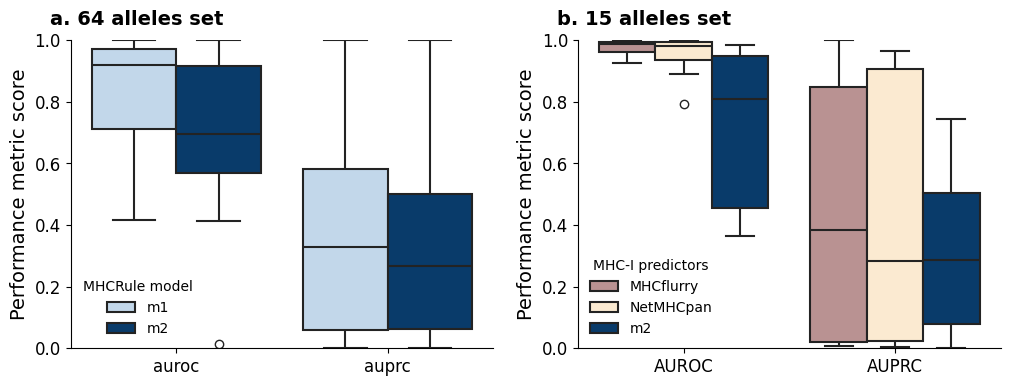

In [50]:
# Create a grid with 1 row and 3 columns, and adjust the width ratio
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # Adjust the width_ratios as needed

# Create subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

plot_df = result_64allele_df[['auroc m1', 'auroc m2', 'auprc m1', 'auprc m2']].melt()
plot_df['MHCRule model'] = ['m1' if 'm1' in i else 'm2' for i in plot_df['variable']]
plot_df['variable'] = ['auroc' if 'auroc' in i else 'auprc' for i in plot_df['variable']]

b = sns.boxplot(data=plot_df.dropna(),
                x='variable', y='value', hue='MHCRule model', 
                ax=ax1, saturation = 0.85, linewidth=1.5,
               palette=color_palette[::-1][:2])

b.set_ylabel('Performance metric score', fontsize=fontsize)
b.set_xlabel('')
b.set(ylim=(0,1))
b.legend(frameon=False, prop={'size': fontsize-4})
b.legend_.set_title("MHCRule model", prop={'size': fontsize-4}) 

# Adding labels 
# Retrieve and modify existing y-axis tick labels fontsize
yticklabels = b.get_yticklabels()
for label in yticklabels:
    label.set_fontsize(fontsize-2)  # Set fontsize to 10
    
xticklabels = [i.get_text() for i in b.get_xticklabels()]
b.set_xticklabels(xticklabels,fontsize=fontsize-2,rotation=0)
b.text(-0.6,1.05,'a. 64 alleles set', fontsize=fontsize, weight='bold')


##################################################
predictors_auroc_df = pd.read_csv('../Data/mhcbench_v2_predictors_AUROC.csv',index_col=0)
predictors_auprc_df = pd.read_csv('../Data/mhcbench_v2_predictors_AUPRC.csv',index_col=0)

predictors_auroc_df = predictors_auroc_df.merge(result_15allele_df,on='allele')
predictors_auprc_df = predictors_auprc_df.merge(result_15allele_df,on='allele')

plot_df_1 = predictors_auroc_df[['MHCflurry-BA','NetMHCpan-BA','auroc']].rename(columns={'auroc':'m2',
                                                                                            'MHCflurry-BA':'MHCflurry',
                                                                                            'NetMHCpan-BA':'NetMHCpan'})
plot_df_1 = plot_df_1.melt().rename(columns={'variable':'MHC-I predictors'})
plot_df_1['variable'] = ['AUROC']*len(plot_df_1)

plot_df_2 = predictors_auprc_df[['MHCflurry-BA','NetMHCpan-BA','auprc']].rename(columns={'auprc':'m2',
                                                                                           'MHCflurry-BA':'MHCflurry',
                                                                                            'NetMHCpan-BA':'NetMHCpan'})
plot_df_2 = plot_df_2.melt().rename(columns={'variable':'MHC-I predictors'})
plot_df_2['variable'] = ['AUPRC']*len(plot_df_2)

b = sns.boxplot(data=pd.concat([plot_df_1,plot_df_2], axis=0).dropna(),
                x='variable', y='value', hue='MHC-I predictors', 
                ax=ax2, saturation = 0.85, linewidth=1.5,
               palette=color_palette[:2]+[color_palette[-2]])


b.set_ylabel('Performance metric score', fontsize=fontsize)
b.set_xlabel('')
b.set(ylim=(0,1))
b.legend(frameon=False, prop={'size': fontsize-4})
b.legend_.set_title("MHC-I predictors", prop={'size': fontsize-4}) 

# Adding labels 
# Retrieve and modify existing y-axis tick labels fontsize
yticklabels = b.get_yticklabels()
for label in yticklabels:
    label.set_fontsize(fontsize-2)  # Set fontsize to 10
    
xticklabels = [i.get_text() for i in b.get_xticklabels()]
b.set_xticklabels(xticklabels,fontsize=fontsize-2,rotation=0)
b.text(-0.6,1.05,'b. 15 alleles set', fontsize=fontsize, weight='bold')

sns.despine(top=True, right=True)
fig.savefig('../figures/generalization/generalization.png',bbox_inches='tight', dpi=dpi)

In [48]:
# Distribution of closest allele in original HLA clus vs our dataset
hla_clus_closest_distance_ls = []

for allele in hla_clus_distance_matrix.columns:
    hla_clus_closest_distance_ls = hla_clus_closest_distance_ls + [hla_clus_distance_matrix[allele].sort_values().iloc[1]]
    
    
print(kruskal(hla_clus_closest_distance_ls, prediction_auroc_df['HLA Clus m1 - m2'].to_list()))


KruskalResult(statistic=69.19967230122845, pvalue=8.898283010081405e-17)


In [49]:
# between predictors and most similar allele

print(pearsonr(predictors_auroc_df['MHCflurry-BA'], 
               predictors_auroc_df['auroc']))
print(pearsonr(predictors_auroc_df['NetMHCpan-BA'], 
               predictors_auroc_df['auroc']))
print(pearsonr(predictors_auprc_df['MHCflurry-BA'], 
               predictors_auprc_df['auprc']))
print(pearsonr(predictors_auprc_df['NetMHCpan-BA'], 
               predictors_auprc_df['auprc']))

print(kruskal(predictors_auroc_df['MHCflurry-BA'], 
               predictors_auroc_df['auroc']))
print(kruskal(predictors_auroc_df['NetMHCpan-BA'], 
               predictors_auroc_df['auroc']))
print(kruskal(predictors_auprc_df['MHCflurry-BA'], 
               predictors_auprc_df['auprc']))
print(kruskal(predictors_auprc_df['NetMHCpan-BA'], 
               predictors_auprc_df['auprc']))

PearsonRResult(statistic=0.42642321018527524, pvalue=0.11295818079514011)
PearsonRResult(statistic=0.5647774080201571, pvalue=0.02826439471964326)
PearsonRResult(statistic=0.49363806075782524, pvalue=0.06147536953605739)
PearsonRResult(statistic=0.5542693728053503, pvalue=0.03202467257531874)
KruskalResult(statistic=14.720430107526894, pvalue=0.0001246878527628901)
KruskalResult(statistic=10.60172043010752, pvalue=0.001129824810582507)
KruskalResult(statistic=0.5268817204301115, pvalue=0.46792080733173624)
KruskalResult(statistic=0.46838709677417967, pvalue=0.49373011668276867)
